# Albumentasi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Blur, RandomBrightnessContrast, HueSaturationValue
)
from pathlib import Path
import random

# Path folder data
data_dir = Path('/content/drive/MyDrive/Capstone/cnn_crop_again/val')
images_dir = data_dir / "crop"
augmented_images_dir = data_dir / "crop"

# Membuat folder output jika belum ada
os.makedirs(augmented_images_dir, exist_ok=True)

# Definisikan pipeline augmentasi
augmentation_pipeline = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    Blur(blur_limit=3, p=0.2),
])

# Fungsi untuk rotasi 90°, 180°, atau 270°
def rotate_image(image):
    # Pilih rotasi secara acak antara 90°, 180°, atau 270°
    angle = random.choice([90, 180, 270])

    if angle == 90:
        image = cv2.transpose(image)
        image = cv2.flip(image, flipCode=1)  # 90° clockwise
    elif angle == 180:
        image = cv2.flip(image, flipCode=-1)  # 180° clockwise
    elif angle == 270:
        image = cv2.transpose(image)
        image = cv2.flip(image, flipCode=0)  # 270° clockwise

    return image

# Fungsi untuk melakukan augmentasi pada gambar
def apply_augmentation(image_filepath):
    # Membaca gambar
    image = cv2.imread(str(image_filepath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Lakukan augmentasi pertama (flip, brightness, saturasi, dll)
    augmented = augmentation_pipeline(image=image)
    augmented_image1 = augmented['image']

    # Lakukan rotasi pada gambar pertama
    augmented_image1 = rotate_image(augmented_image1)

    # Mengubah nama file hasil augmentasi pertama
    augmented_image_filename1 = image_filepath.stem + "_aug1.jpg"
    augmented_image_filepath1 = augmented_images_dir / augmented_image_filename1

    # Mengonversi gambar kembali ke format BGR untuk disimpan dengan OpenCV
    augmented_image1 = cv2.cvtColor(augmented_image1, cv2.COLOR_RGB2BGR)
    cv2.imwrite(str(augmented_image_filepath1), augmented_image1)

    # Lakukan augmentasi kedua (flip, brightness, saturasi, dll)
    augmented = augmentation_pipeline(image=image)
    augmented_image2 = augmented['image']

    # Lakukan rotasi pada gambar kedua
    augmented_image2 = rotate_image(augmented_image2)

    # Mengubah nama file hasil augmentasi kedua
    augmented_image_filename2 = image_filepath.stem + "_aug2.jpg"
    augmented_image_filepath2 = augmented_images_dir / augmented_image_filename2

    # Mengonversi gambar kembali ke format BGR untuk disimpan dengan OpenCV
    augmented_image2 = cv2.cvtColor(augmented_image2, cv2.COLOR_RGB2BGR)
    cv2.imwrite(str(augmented_image_filepath2), augmented_image2)

# Loop untuk augmentasi gambar
for image_filename in os.listdir(images_dir):
    if image_filename.endswith(".jpg"):
        image_filepath = images_dir / image_filename
        apply_augmentation(image_filepath)

print("Proses augmentasi selesai.")


Proses augmentasi selesai.


# Crop FIX

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Direktori dataset
train_dir = '/content/drive/MyDrive/Capstone/cnn_crop_again/train'
test_dir = '/content/drive/MyDrive/Capstone/cnn_crop_again/val'

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Ukuran gambar
    batch_size=32  # Ukuran batch
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),  # Ukuran gambar
    batch_size=32  # Ukuran batch
)


Found 1238 files belonging to 2 classes.
Found 572 files belonging to 2 classes.


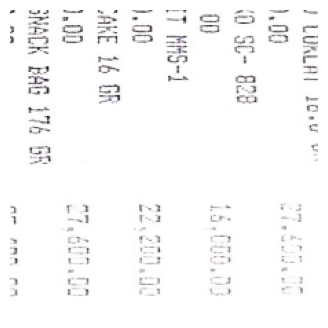

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
dataset_iterator = train_dataset.as_numpy_iterator()  # Convert to iterator
x_train, y_train = next(dataset_iterator)  # Get next batch
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.show()


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Input layer dengan normalisasi gambar
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1.0 / 255),  # Normalisasi gambar ke range [0, 1]

    # Lapisan konvolusi dan pooling
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten untuk melanjutkan ke lapisan fully connected
    tf.keras.layers.Flatten(),

    # Fully connected layer dengan regularisasi L2
    #tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),

    # Dropout layer untuk mengurangi overfitting
    tf.keras.layers.Dropout(0.5),  # Mematikan 50% neuron di lapisan ini

    # Output layer untuk 2 kelas: valid dan blur
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),  # Atur learning rate
    loss='binary_crossentropy',          # Karena klasifikasi biner
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      47,776,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,814,977 (182.40 MB)

 Trainable params: 47,814,977 (182.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 954ms/step - accuracy: 0.5994 - loss: 8.6630 - val_accuracy: 0.6293 - val_loss: 2.7671
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 474ms/step - accuracy: 0.7815 - loss: 2.6340 - val_accuracy: 0.9138 - val_loss: 1.5228
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 546ms/step - accuracy: 0.9265 - loss: 1.2955 - val_accuracy: 0.8879 - val_loss: 0.9614
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.9142 - loss: 0.8628 - val_accuracy: 0.9310 - val_loss: 0.6229
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 476ms/step - accuracy: 0.9584 - loss: 0.5542 - val_accuracy: 0.9483 - val_loss: 0.4327
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 602ms/step - accuracy: 0.9517 - loss: 0.4287 - val_accuracy: 0.9397 - val_loss: 0.3754
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 635ms/step - accuracy: 0.9684 - loss: 0.3270 - val_accuracy: 0.9397 - val_loss: 0.3104
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 464ms/step - accuracy: 0.9559 - loss: 0.2927 - val_accurac

In [ ]:
# Mengevaluasi model pada data pengujian
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step - accuracy: 0.9820 - loss: 0.2300
Test Accuracy: 0.9655172228813171
Test Loss: 0.23348791897296906


In [ ]:
# Menyimpan model ke file .h5
model.save('/content/drive/MyDrive/Capstone/model_cnn_cropbanyak_again.h5')


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Memuat model dari file .h5
model = load_model('/content/drive/MyDrive/Capstone/model_cnn_cropbanyak_again.h5')

# Menyusun model (compile) jika Anda ingin melanjutkan pelatihan atau evaluasi
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Mengonversi model ke format JSON
model_json = model.to_json()

# Menyimpan model dalam format JSON
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
# Install tensorflowjs

!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 85.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uni

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf

# Rekonstruksi model
model = tf.keras.Sequential([
    # Input layer dengan normalisasi gambar
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1.0 / 255),  # Normalisasi gambar ke range [0, 1]

    # Lapisan konvolusi dan pooling
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten untuk melanjutkan ke lapisan fully connected
    tf.keras.layers.Flatten(),

    # Fully connected layer dengan regularisasi L2
    #tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),

    # Dropout layer untuk mengurangi overfitting
    tf.keras.layers.Dropout(0.5),  # Mematikan 50% neuron di lapisan ini

    # Output layer untuk 2 kelas: valid dan blur
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Muat bobot ke model rekonstruksi
model.load_weights('/content/drive/MyDrive/Capstone/model_cnn_cropbanyak_again.h5')

# Simpan model lengkap (arsitektur + bobot)
model.save('/content/drive/MyDrive/Capstone/model_cropppp.h5')


In [ ]:
# mengubah model.h5 kedalam bentuk jsonmodel_cnn_cropbanyak_again
!tensorflowjs_converter --input_format=keras /content/drive/MyDrive/Capstone/model_cropppp.h5 tfjs_model

2024-12-05 10:18:18.481230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733393898.501899   16756 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733393898.508168   16756 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
from tensorflow.keras.models import load_model

# Muat kembali file .h5 untuk memverifikasi
model_test = load_model('/content/drive/MyDrive/Capstone/model_cropppp.h5')
print(model_test.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      47,776,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,814,977 (182.40 MB)

 Trainable params: 47,814,977 (182.40 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


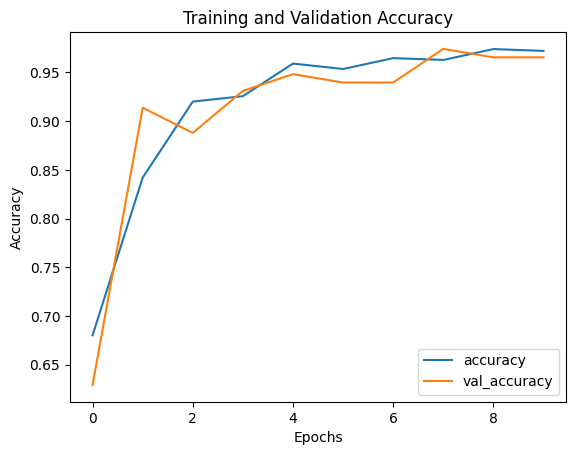

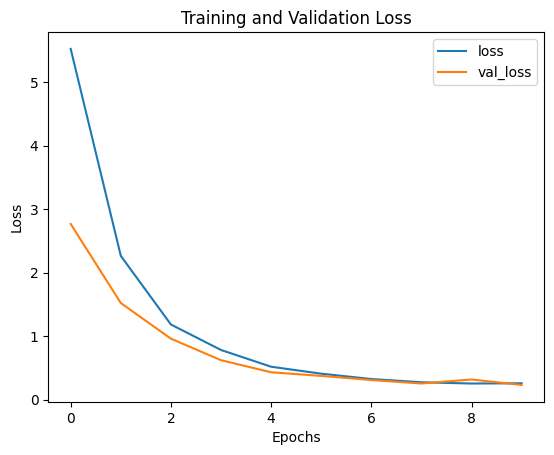

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi pelatihan dan validasi
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot kehilangan pelatihan dan validasi
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Found 572 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 140s 8s/step


<ipython-input-24-58be31142dc4>:32: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


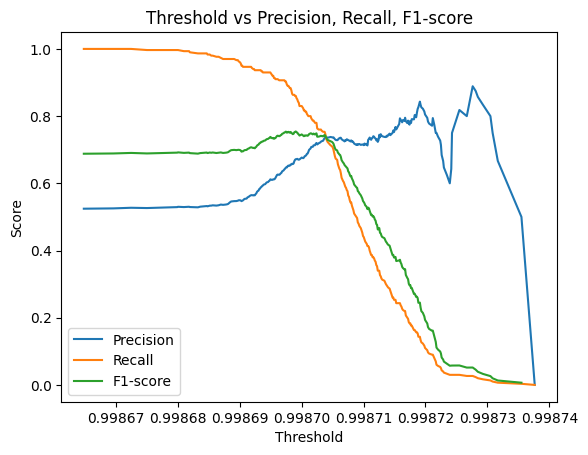

Optimal threshold: 0.998737633228302


In [ ]:
#Mencari Optimal Threshold
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


# Memuat model yang sudah dilatih (sesuaikan dengan path model Anda)
model = load_model('/content/drive/MyDrive/Capstone/model_cnn_cropbanyak_again.h5')  # Gantilah dengan path model Anda

# Definisikan ImageDataGenerator untuk memuat dataset validasi
datagen = ImageDataGenerator(rescale=1./255)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Capstone/cnn_crop_again/val',
    target_size=(224, 224),  # Sesuaikan dengan ukuran input model
    batch_size=32,
    class_mode='binary',  # Pastikan ini sesuai dengan jenis klasifikasi (binary)
    shuffle=False)  # Agar urutan prediksi dan label tetap sesuai

# Mendapatkan label sebenarnya (y_true)
y_true = validation_generator.classes  # Ini adalah label asli dari dataset

# Mendapatkan prediksi probabilitas
predictions = model.predict(validation_generator, verbose=1)

# Menghitung precision, recall, dan thresholds
precision, recall, thresholds = precision_recall_curve(y_true, predictions)

# Menghitung F1-score untuk setiap threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Menampilkan hasil
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Threshold vs Precision, Recall, F1-score')
plt.show()

# Cari threshold dengan F1-score terbaik
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Optimal threshold: {best_threshold}')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Memuat model yang telah disimpan
model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/model_cnn_cropbanyak_again.h5')

# Fungsi untuk memuat dan memproses gambar baru
def load_and_preprocess_image(img_path):
    # Memuat gambar dan mengubah ukurannya sesuai dengan ukuran input model
    img = image.load_img(img_path, target_size=(224, 224))

    # Mengubah gambar menjadi array
    img_array = image.img_to_array(img)

    # Menambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar ke rentang [0, 1]
    img_array = img_array / 255.0

    return img_array

# Fungsi untuk melakukan prediksi
def predict_image_class(img_path):
    img_array = load_and_preprocess_image(img_path)

    # Melakukan prediksi
    predictions = model.predict(img_array)

    # Mengonversi probabilitas
    predicted_class = (predictions < 0.998701572 ).astype("int32")

    # Menampilkan hasil prediksi
    if predicted_class == 0:
        print(f"The image is classified as 'Valid'.")
    else:
        print(f"The image is classified as 'Crop'.")
    print(predictions)

# Path ke gambar yang ingin diuji
#img_path = '/content/drive/MyDrive/Capstone/data_testing/valid/valid 2.jpg'  # Ganti dengan path gambar Anda yang ingin diuji

# Melakukan prediksi
#predict_image_class(img_path)

Testing image: valid 1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The image is classified as 'Valid'.
[[0.9987031]]


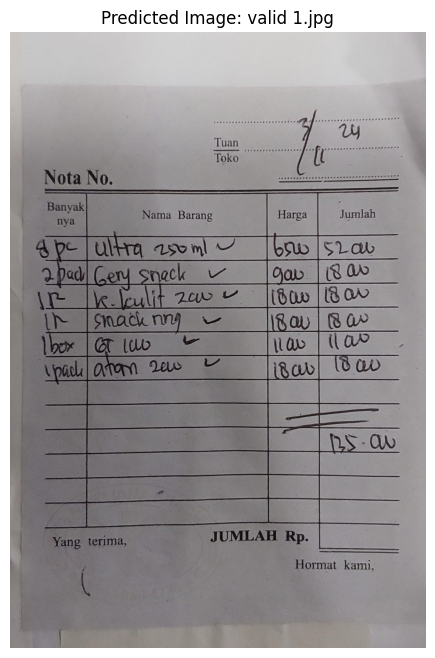

Testing image: valid 2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The image is classified as 'Crop'.
[[0.9987006]]


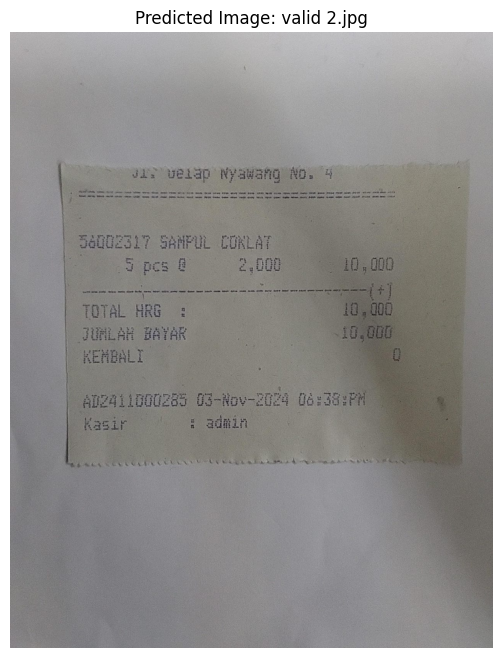

Testing image: WhatsApp Image 2024-11-30 at 14.03.04.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The image is classified as 'Valid'.
[[0.9987262]]


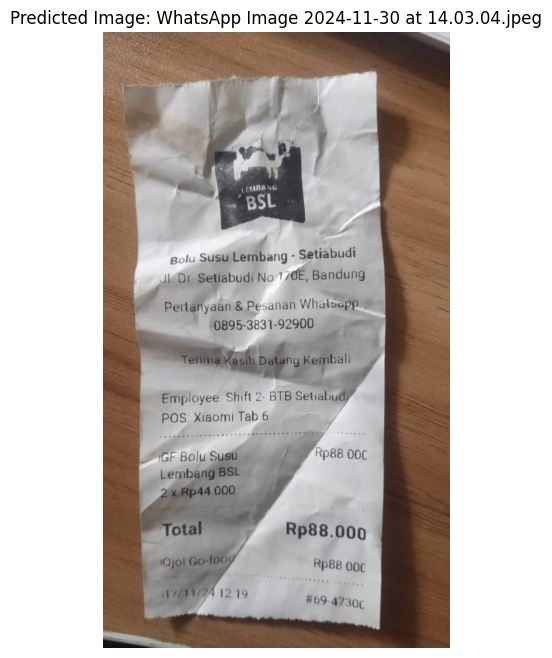

Testing image: WhatsApp Image 2024-11-30 at 14.03.05.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The image is classified as 'Valid'.
[[0.99872416]]


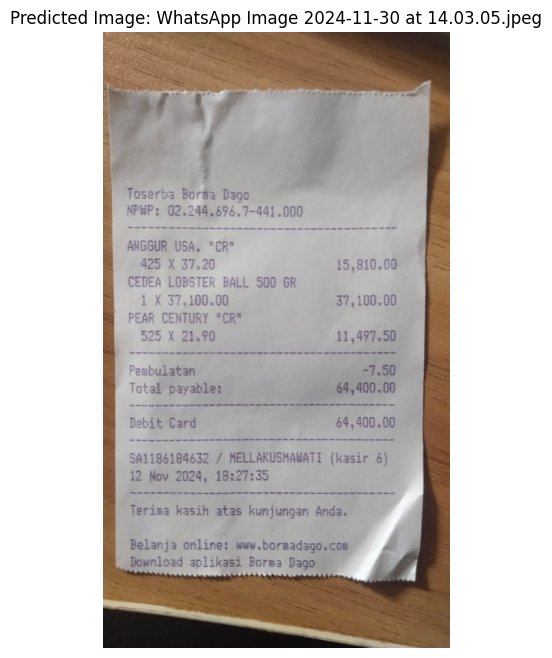

Testing image: WhatsApp Image 2024-11-30 at 14.03.12.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The image is classified as 'Valid'.
[[0.9987257]]


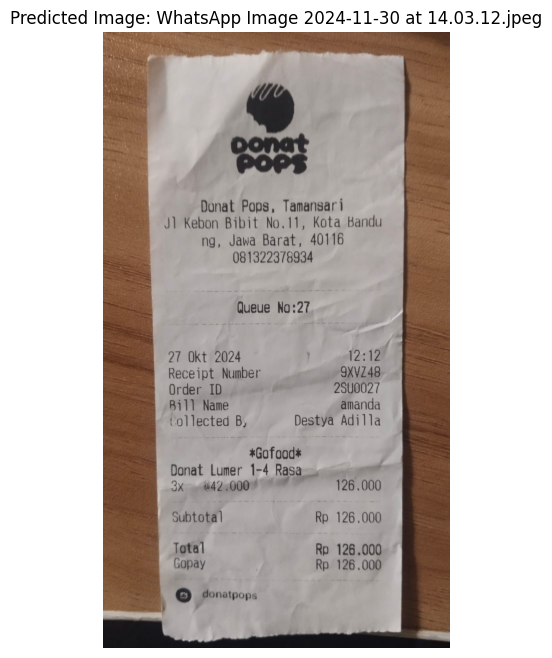

Testing image: WhatsApp Image 2024-11-30 at 14.03.23.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
The image is classified as 'Crop'.
[[0.99868613]]


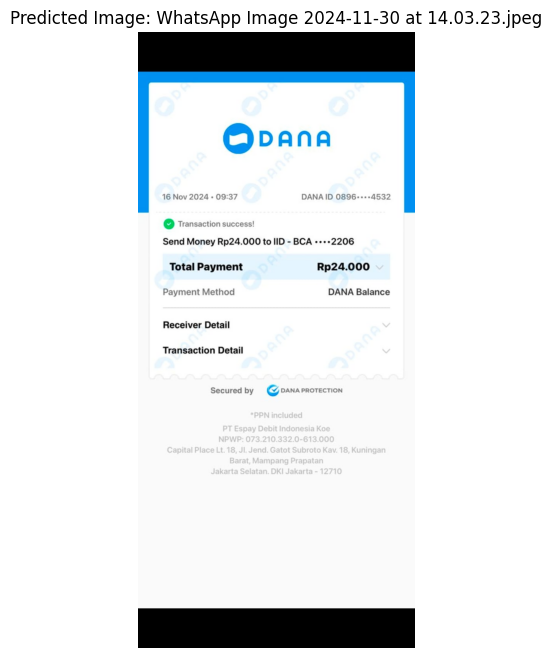

Testing image: WhatsApp Image 2024-12-02 at 23.58.34.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The image is classified as 'Valid'.
[[0.99873704]]


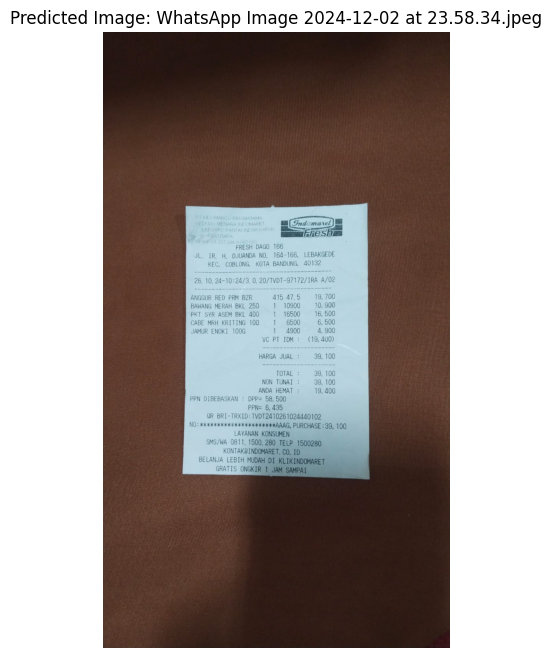

Testing image: WhatsApp Image 2024-12-02 at 23.58.34 (2).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The image is classified as 'Valid'.
[[0.9987287]]


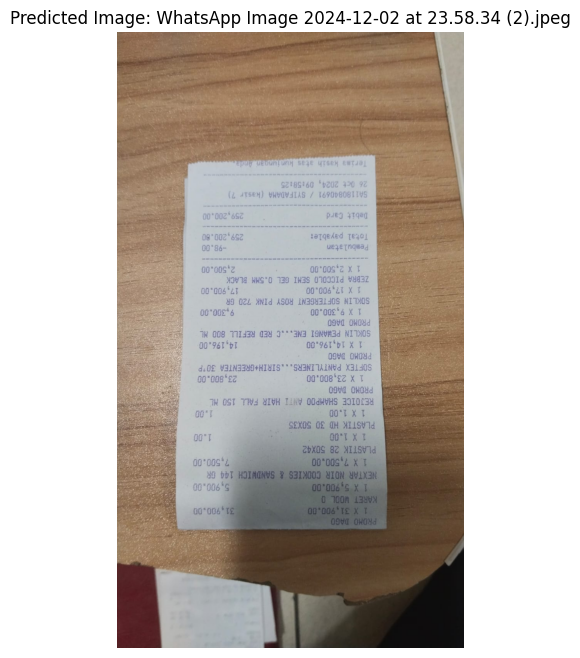

Testing image: WhatsApp Image 2024-12-02 at 23.58.34 (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The image is classified as 'Valid'.
[[0.99875295]]


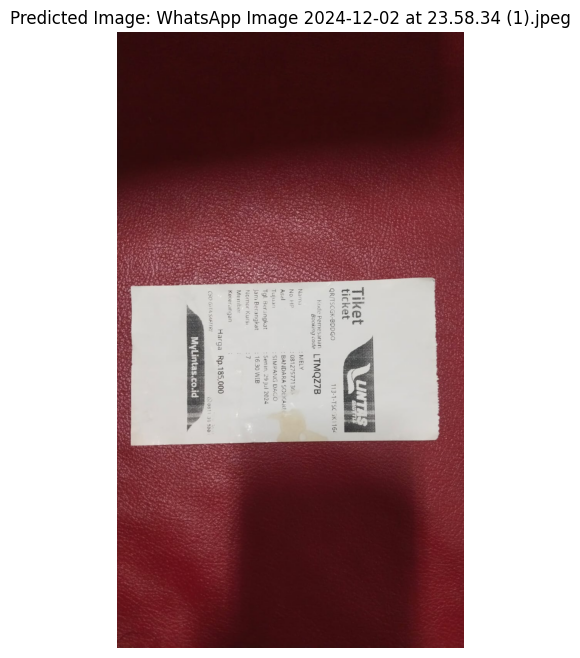

Testing image: WhatsApp Image 2024-12-02 at 23.58.35.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
The image is classified as 'Valid'.
[[0.9987614]]


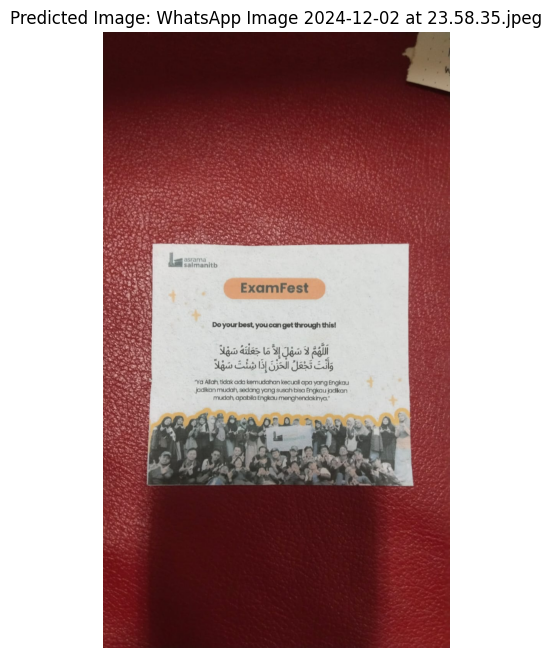

Testing image: WhatsApp Image 2024-12-02 at 23.58.35 (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The image is classified as 'Valid'.
[[0.99872005]]


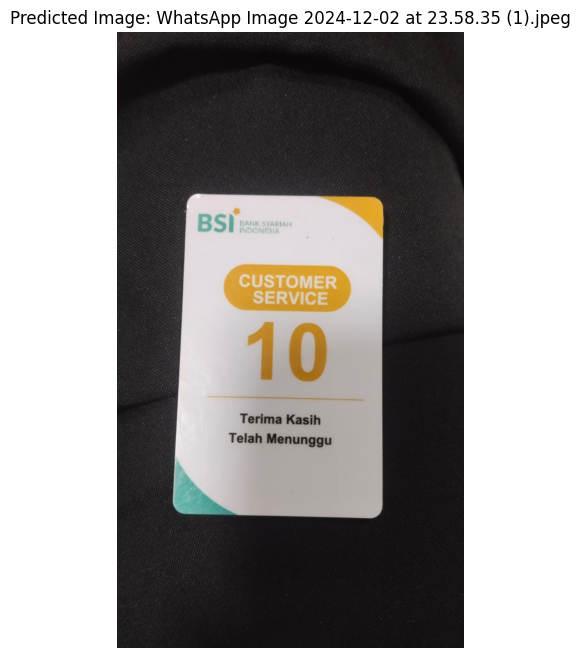

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

#TESTING MULTIPLE IMAGES
# Fungsi untuk menguji semua gambar dalam folder

def test_and_display_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Pastikan hanya memproses file gambar
            img_path = os.path.join(folder_path, filename)
            print(f"Testing image: {filename}")
            predict_image_class(img_path)

            # Membaca gambar
            image = cv2.imread(img_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengonversi ke RGB untuk tampilan yang benar

            # Tampilkan gambar menggunakan matplotlib
            plt.figure(figsize=(8, 8))
            plt.imshow(image_rgb)
            plt.title(f"Predicted Image: {os.path.basename(img_path)}")  # Judul gambar dengan nama file
            plt.axis('off')  # Menyembunyikan axis
            plt.show()

# Folder tempat gambar yang ingin diuji
test_folder = '/content/drive/MyDrive/Capstone/data_testing/valid'  #kontras kertas dgn background
#test_folder = '/content/drive/MyDrive/Capstone/data_testing/crop'  #terang dan sama warna keseluruhannya
# Melakukan testing pada semua gambar dalam folder
test_and_display_images_in_folder(test_folder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


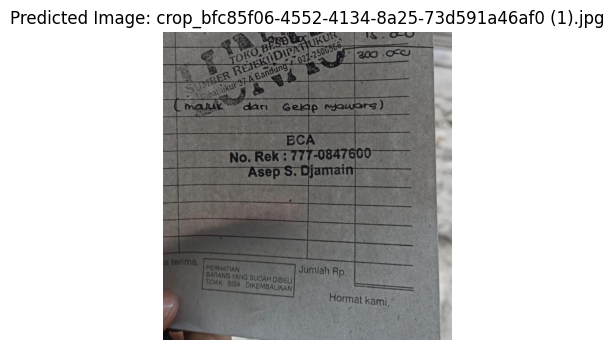

Predicted Class: [[1]]
[[0.9987093]]


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

# Membaca gambar baru
img_path = '/content/drive/MyDrive/Capstone/Cropped/crop_bfc85f06-4552-4134-8a25-73d591a46af0 (1).jpg'  # Ganti dengan path gambar Anda
img = image.load_img(img_path, target_size=(224, 224))

# Mengubah gambar menjadi array
img_array = image.img_to_array(img)

# Menambahkan dimensi batch
img_array = np.expand_dims(img_array, axis=0)

# Normalisasi gambar
img_array = img_array / 255.0

# Melakukan prediksi
predictions = model.predict(img_array)
#predicted_class = np.argmax(predictions, axis=1)
predicted_class = (predictions > 0.5).astype("int32")

image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengonversi ke RGB untuk tampilan yang benar
plt.figure(figsize=(4, 4))
plt.imshow(image_rgb)
plt.title(f"Predicted Image: {os.path.basename(img_path)}")  # Judul gambar dengan nama file
plt.axis('off')  # Menyembunyikan axis
plt.show()


# Menampilkan kelas yang diprediksi
print(f"Predicted Class: {predicted_class}")
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


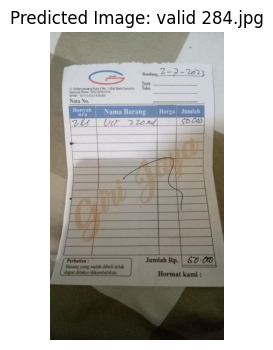

Predicted Class: [[1]]
[[0.99806935]]


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Membaca gambar baru
img_path = '/content/drive/MyDrive/Capstone/dataset/train/valid/valid 284.jpg'  # Ganti dengan path gambar Anda
img = image.load_img(img_path, target_size=(224, 224))

# Mengubah gambar menjadi array
img_array = image.img_to_array(img)

# Menambahkan dimensi batch
img_array = np.expand_dims(img_array, axis=0)

# Normalisasi gambar
img_array = img_array #KAYANYA GARA GARA INI belum dibagi 255

# Melakukan prediksi
predictions = model.predict(img_array)
#predicted_class = np.argmax(predictions, axis=1)
predicted_class = (predictions > 0.5).astype("int32")

image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengonversi ke RGB untuk tampilan yang benar
plt.figure(figsize=(4, 4))
plt.imshow(image_rgb)
plt.title(f"Predicted Image: {os.path.basename(img_path)}")  # Judul gambar dengan nama file
plt.axis('off')  # Menyembunyikan axis
plt.show()

# Menampilkan kelas yang diprediksi
print(f"Predicted Class: {predicted_class}")
print(predictions)